In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

import sys
sys.path.append("../")
import mymodule2 as mm
from exp_guitare_configs import *

from data_loader import *

%matplotlib widget

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (12,4)

/usr/local/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [2]:
def esprit_on_band(RI, fs, lowcut, highcut, poles, order=5, len_esprit=512*7, plot_result=False, number_of_max = 4, Nfft=100000) :
    """
    Cette fonction utilise l'algorithme ESPRIT sur une bande de fréquence particulière.
    Il calcul aussi la réponse en fréquence, et les amplitudes de cette réponses aux fréquence trouvées par ESPRIT.

    ## Inputs
    - `RI` : réponse impulsionnelle d'entrée
    - `fs` : fréquence d'échantillonnage
    - `lowcut` : fréquence de coupure basse du filtre à appliquer
    - `highcut` : fréquence de coupure haute du filtre à appliquer
    - `poles` : nombre de pôles calculés par ESPRIT
    - `order` : ordre du filtre butterworth utilisé
    - `len_esprit` : longueur de la portion ud signal donnée à ESPRIT
    - `plot_result` : trace la réponse en fréquence avec les fréquences trouvées par ESPRIT si `True`
    - `Nfft` : nombre de points pour la FFT

    ## Outputs
    - `freq_amp_sorted` : arrayLike, liste des fréquences trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    - `delta_amp_sorted` : arrayLike, liste des amortissements trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    """

    RI_filtered = mm.bandpass_filter(RI, lowcut, highcut, fs, order=order)
    fk, deltak = mm.ESPRIT(RI_filtered[:len_esprit], len_esprit//2, poles, return_pos=True)

    Y = np.fft.rfft(RI_filtered, Nfft)
    fy = np.fft.rfftfreq(Nfft,1/fs)

    #Calcul des amplitudes de la réponse en fréquences aux fréquences trouvées par ESPRIT
    amp = np.zeros(len(fk))
    for i in range(len(fk)) :
        fk_idx = mm.find_nearest_index(fy, fk[i]*fs)
        amp[i] = 20*np.log10(np.abs(Y[fk_idx]))
    freq_amp_sorted = fk[amp.argsort()[-number_of_max:][::-1]]*fs
    delta_amp_sorted = deltak[amp.argsort()[-number_of_max:][::-1]]

    if plot_result :
        fig = plt.figure()
        ax1 = fig.add_subplot(111)


        ax1.semilogx(fy,20*np.log10(np.abs(Y)),label="")
        ax1.grid(which="both")
        #ax1.legend()
        ax1.set_xlabel("Fréquences $(Hz)$")
        ax1.set_ylabel("FFT $(dB)$")
        ax1.set_title(r"Réponse en fréquence filtrée, superposée à ESPRIT")
        ax1.set_xlim(30,2000)
        ylims = ax1.set_ylim()
        ax1.vlines(fk*fs, ylims[0], ylims[1], alpha=0.4, color="black", ls="--")

        import matplotlib.ticker as mticker
        ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
        
        fig.tight_layout()

        plt.show()

    return freq_amp_sorted, delta_amp_sorted
    

In [3]:
def plot_frfs_mat(idx_mat) :
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.semilogx(deforme_Nta_Npos[idx_mat,0]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,0]["FRF"])),label="pos 1")
    ax1.semilogx(deforme_Nta_Npos[idx_mat,1]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,1]["FRF"])),label="pos 2")
    ax1.grid(which="both")
    ax1.set_title(f"Matériau : {deforme_Nta_Npos[idx_mat,0]['mat_table']}")
    ax1.set_ylabel("")
    ax1.set_xlabel("Fréquences $(Hz)$")
    ax1.legend()
    ax1.set_xlim(30,2000)
    ylims = ax1.set_ylim()

    import matplotlib.ticker as mticker
    ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())

    fig.tight_layout()

    plt.show()

# Analyse des tables : protocole

- Choisir un indice de matériau $i_m$ entre les 4 indices [0,1,2,3].
- Tracer la réponse en fréquence pour les 2 positions de frappe avec `plot_frfs_mat(idx_mat)` : l'idée est d'observer à la main où sont les pics en fréquences.
- Accéder aux réponses impulsionnelle avec `deforme_Nta_Npos[idx_mat, 0]`, `deforme_Nta_Npos[idx_mat, 1]`.
- Sélectionner à l'oeil une bande de fréquence où il y a un ou plusieurs pics, et utiliser `esprit_on_band()` pour appliquer esprit sur cette bande de fréquence.
- Sélectionner les fréquences cohérentes avec les pics, et les amortissements, à noter quelque part.
- Faire cela pour une vingtaine de mode par plaque.

In [4]:
idx_mat = 2 #Je choisis le matériau d'indice 1

dico_pos1 = deforme_Nta_Npos[idx_mat,0]
dico_pos2 = deforme_Nta_Npos[idx_mat,1]

print(dico_pos1["mat_table"]) #C'est donc le plexi

Plexi


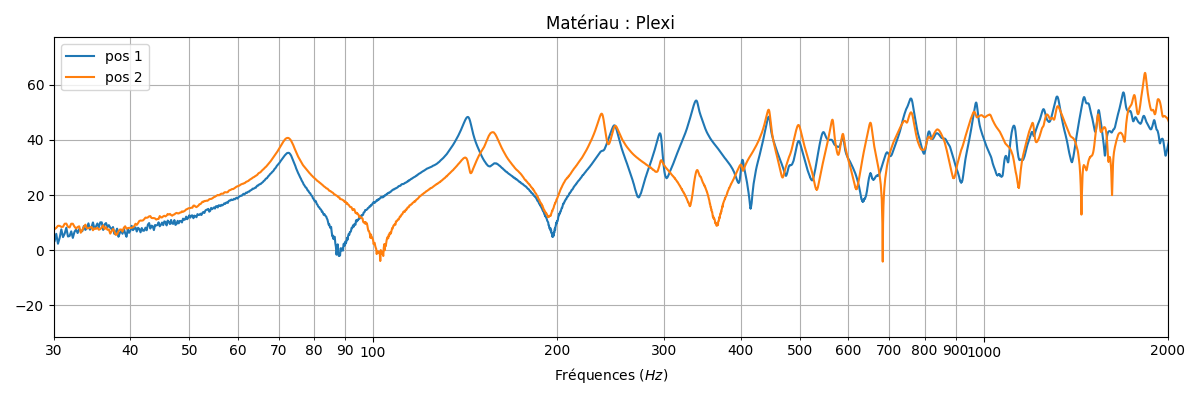

In [5]:
plot_frfs_mat(idx_mat)

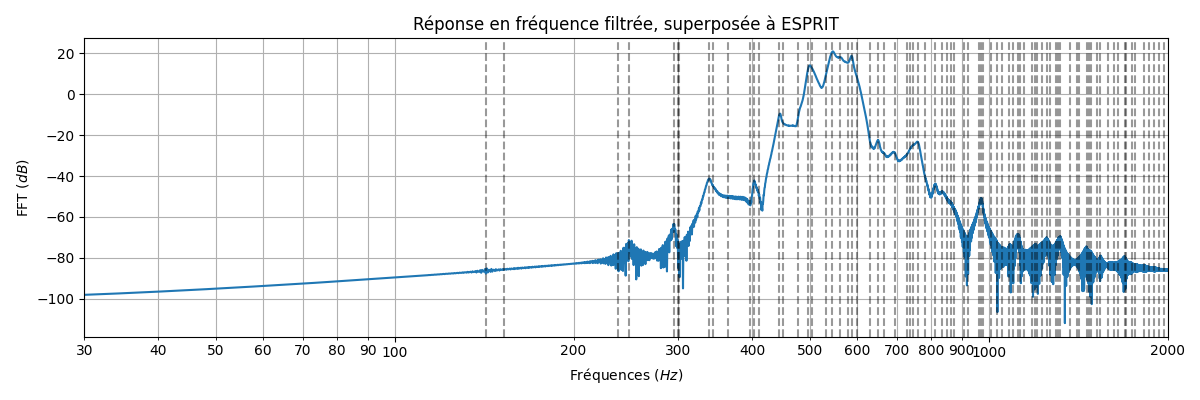

In [20]:
fk, deltak = esprit_on_band(dico_pos1["RI"], dico_pos1["fs"], 500, 600, 200, order=100, plot_result=True, len_esprit=512*10, number_of_max=10)
# print(fk)
# print(deltak)

In [21]:
fk

array([545.17710008, 587.92665334, 561.25346576, 579.40572924,
       503.13766061, 496.85034774, 531.43676212, 600.66454147,
       443.80576762, 477.28575812])

In [22]:
deltak

array([-0.00082278, -0.00037726, -0.00075488, -0.00261656, -0.00124823,
       -0.00059556, -0.0020802 , -0.00174158, -0.00047569, -0.00040611])

In [32]:
import pandas as pd

modal_analysis = {
    "table" : dico_pos1["mat_table"],
    "freq" : np.array([72.09741278, 142.14215793, 156.59010082, 236.7269505, 248.2530023, 294.94358678, 337.50039829, 402.02166775, 444.4563055, 480, 496.89932282, 545.17710008, 561.25346576, 587.92665334]),
    "xi" : np.array([-0.00020138, -0.00021048, -4.5004e-4, -0.00035561, -0.00039229, -1.52620143e-04, -0.00050664, -0.00031898, -0.00036209, -0.00027529, -0.00058368, -0.00082278, -0.00075488, -0.00037726]),
}

modal_analysis["ratios"] = modal_analysis["freq"]/modal_analysis["freq"][0]

modal_analysis = pd.DataFrame(modal_analysis).T
modal_analysis

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
table,Plexi,Plexi,Plexi,Plexi,Plexi,Plexi,Plexi,Plexi,Plexi,Plexi,Plexi,Plexi,Plexi,Plexi
freq,72.097413,142.142158,156.590101,236.72695,248.253002,294.943587,337.500398,402.021668,444.456305,480.0,496.899323,545.1771,561.253466,587.926653
xi,-0.000201,-0.00021,-0.00045,-0.000356,-0.000392,-0.000153,-0.000507,-0.000319,-0.000362,-0.000275,-0.000584,-0.000823,-0.000755,-0.000377
ratios,1.0,1.971529,2.171924,3.283432,3.4433,4.090904,4.681172,5.57609,6.164664,6.657659,6.892055,7.561674,7.784655,8.154615
